# FIT5196 Task 2 in Assessment 2
#### Student Name: Boyu Zhang
#### Student ID: 28491300

Date: XX/XX/XXXX

Version: 1.0

Environment: Python 3.6 and Jupyter notebook

Libraries used: please include the main libraries you used in your assignment here, e.g.,:
* pandas (for dataframe, included in Anaconda Python 3.6) 
* numpy (for numpy array, included in Anaconda Python 3.6)
* sklearn (for missing value imputation model, installed by `conda install scikit-learn`)
* scipy (for some statistical computing like the pearson r, included in Anaconda Python3.6)
* itertools (for get unique pairs of features, built-in in Python 3.6)

## 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import warnings
from scipy import stats 
from itertools import combinations
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 2. Load data and exploration

In [2]:
df3 = pd.read_csv('./Input/dataset3_with_missing.csv')

In [3]:
#get the number of missing values for each columns
df3.isnull().sum()

id                 0
date               0
price              0
bedrooms           0
bathrooms        400
sqft_living       66
sqft_lot           0
floors             0
waterfront         0
view               0
condition          0
grade              0
sqft_above        67
sqft_basement     67
yr_built           0
yr_renovated       0
zipcode            0
lat                0
long               0
dtype: int64

### columns that show explicit clue of missing data:
- sqft_living : 66
- sqft_above : 67
- sqft_basement : 67
- bathrooms : 400


## 3.  Missing value imputation

###  3.1. The 3 `sqfts`

- First we look at the remaining 3 columns `sqft_living`, `sqft_above`, `sqft_base`.
- The number of missing values in the 3 columns is quite close to each other
- According to the dataset description we can guess that there is a correlation between the `sqft_living`, `sqft_above`, `sqft_base`.
And it seems reasonable that they are independent to other features.
- From the description of the dataset, we can infer that in usual cases the `sqft_living` should be the sum of `sqft_above` and `sqft_base`.That is `sqft_living = sqft_aboce + sqft_basement`

So we need to check whether this correlation is true

In [4]:
three_sqfts = df3[~(df3.sqft_living == df3.sqft_above + df3.sqft_basement)][['sqft_living','sqft_above','sqft_basement']]

In [5]:
three_sqfts.head(10)

,sqft_living,sqft_above,sqft_basement
146,2450.0,NaN,0.0
189,NaN,1630.0,0.0
250,1010.0,NaN,0.0
326,2130.0,NaN,1030.0
338,1490.0,NaN,0.0
393,960.0,NaN,0.0
434,2320.0,1160.0,NaN
483,NaN,1010.0,720.0
503,1290.0,1290.0,NaN
509,1440.0,NaN,480.0


### Reasoning
- From the above result, we know that for most of the records the correlation can be proved, the rows that doesn't show this pattern is all due to that there are missing values in these three columns
#### *Precondition:
To be able to impute the missing values based on our inference, it is necessary that for all records, no more than one column of the three columns should be missing

In [6]:
# check whether the preconditon above is satisfied
np.array(three_sqfts.shape) - np.array(three_sqfts.dropna(thresh=2).shape)

array([0, 0])

The result of above check is a zero-shape array which means we in each record, if there is a missing value in **one** of the three columns, the other **two** must have valid values.
So we can start the imputation on these three columns

In [7]:
#impute missing values using the proved equation
df3.sqft_living = df3.sqft_living.fillna(df3.sqft_above + df3.sqft_basement)
df3.sqft_above = df3.sqft_above.fillna(df3.sqft_living - df3.sqft_basement)
df3.sqft_basement = df3.sqft_basement.fillna(df3.sqft_living - df3.sqft_above)

In [8]:
df3.isnull().sum()

id                 0
date               0
price              0
bedrooms           0
bathrooms        400
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
view               0
condition          0
grade              0
sqft_above         0
sqft_basement      0
yr_built           0
yr_renovated       0
zipcode            0
lat                0
long               0
dtype: int64

So we finished the missing value imputation of these 3 columns.

## 3.2 The `bathroom`

First we split out the proportion of the dataset that don't have missing value `bathroom` column

In [9]:
df = df3[~df3.bathrooms.isna()]
df_miss = df3[df3.bathrooms.isna()]

In [10]:
#get the features with their pearson r larger than 0.5 which is strong relevant
pairs = []
for i in list(df.columns):
    pairs.append((i,'bathrooms'))
correlation = []
for pair in pairs:
    try:
        r = stats.pearsonr(df[pair[0]],df[pair[1]])[0]
        if abs(r) > 0.5:
            correlation.append([pair,r])
            
    except:
        pass

In [11]:
sorted(correlation,key=lambda x: x[-1],reverse=True)

[[('bathrooms', 'bathrooms'), 1.0],
 [('sqft_living', 'bathrooms'), 0.7934687961093732],
 [('sqft_above', 'bathrooms'), 0.7100975105730197],
 [('grade', 'bathrooms'), 0.6809540413787357],
 [('price', 'bathrooms'), 0.5192078916897007],
 [('floors', 'bathrooms'), 0.5182340337195713],
 [('yr_built', 'bathrooms'), 0.514761542446788],
 [('bedrooms', 'bathrooms'), 0.5140708222502688]]

### Reasoning
- It is meaningful first think about what features can be potentially correlated with the number of bathrooms in a house.
- It appears that `bathrooms` is a continous numeric value, thus it is more suitable impute it from other continous numeric features, using any categorical features will probably harm the correlation obtained by imputation model
- We determine that these features are potentially correlated: `sqft_lving`,`sqft_above`,`grade`,`price`,`floors`,`yr_built`,`bedrooms`

We then find the features that is with highest level of relations to `bathrooms`

Let's visualize the correlation of the features paring wiht the `bathroom` one by one:

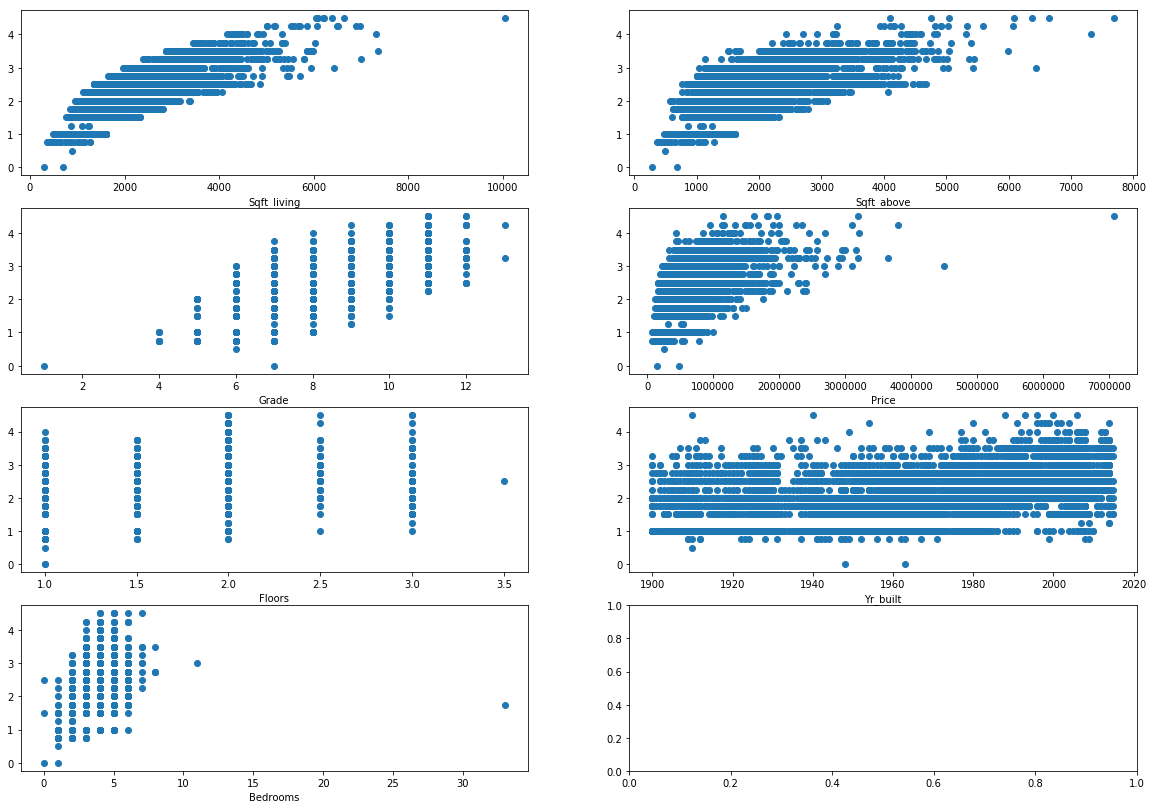

In [12]:
# visualize scatterplots of all potential determing features and bathrooms
y = df.bathrooms
x1 = df.sqft_living
x2 = df.sqft_above
x3 = df.grade
x4 = df.price
x5 = df.floors
x6 = df.yr_built
x7 = df.bedrooms


plt.subplots(4,2,figsize=(20,14))
plt.subplot(4,2,1)
plt.scatter(x=x1,y=y)
plt.xlabel('Sqft_living')

plt.subplot(4,2,2)
plt.scatter(x=x2,y=y)
plt.xlabel('Sqft_above')

plt.subplot(4,2,3)
plt.scatter(x=x3,y=y)
plt.xlabel('Grade')

plt.subplot(4,2,4)
plt.scatter(x=x4,y=y)
plt.xlabel('Price')

plt.subplot(4,2,5)
plt.scatter(x=x5,y=y)
plt.xlabel('Floors')

plt.subplot(4,2,6)
plt.scatter(x=x6,y=y)
plt.xlabel('Yr_built')

plt.subplot(4,2,7)
plt.scatter(x=x7,y=y)
plt.xlabel('Bedrooms')


plt.show()

### Select features to be used for imputation
- After viewing in scatterplots of the more relevant features, we find that 4 features seems feasible to be used
- Tey are: `grade`,`sqft_living` ,`sqft_above` and `price`

### Further analysis
- If we choose to do imputation based on single feature and the `bathroom`, we need to justify which one to choose
- Or if we choose to do imputation based on multiple features, then we need to have valid prove that these features are at least independent to some extent.

### Test correlation for feature selection

In [13]:
features = ['grade','sqft_living','sqft_above','price']

In [14]:
relation = []
for i in combinations(features,2):
    relation.append([i,stats.pearsonr(df[i[0]],df[i[1]])])
relation

[[('grade', 'sqft_living'), (0.7699879409962327, 0.0)],
 [('grade', 'sqft_above'), (0.7619950379794379, 0.0)],
 [('grade', 'price'), (0.679477529016689, 0.0)],
 [('sqft_living', 'sqft_above'), (0.8685280413853901, 0.0)],
 [('sqft_living', 'price'), (0.6919439946892895, 0.0)],
 [('sqft_above', 'price'), (0.5937161711859192, 0.0)]]

### Feature selection decision:
- This means **all** features are **strongly** related thus we cannot use combination of them to do linear regression imputation
- Thus we cannot pick multiple features since they are obviously correlated

**Decision**:

From the fore-shown vaisualization of relation between featuers and `bathrooms`, it is clear that `sqft_living` gives the closest correlation with the smallest width of scatter area, and least seemingly outliers.
So we pick it as the feature that we will use for imputation.

### Imputation
It seems that the correlation of `sqft_living` and `bathrooms` is not linear.
So if we want to use linear regression to impute the missing values, it is better we do the tranformation of data first

According to the tuckey' laddder theory
![](./ladder.png)
The shape of the two feature is Q4 shape, so one option of us is the **log transformation** with **X**

In [15]:
df['grade_transformed'] = np.log(df.grade)

In [16]:
df['living_transformed'] = np.log(df.sqft_living)
df_miss['living_transformed'] = np.log(df_miss.sqft_living)

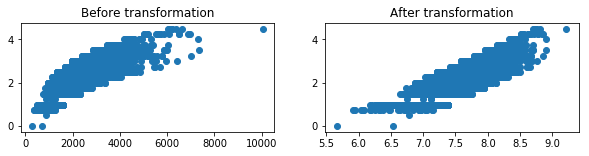

In [17]:
plt.subplots(1,2,figsize=(10,2))
plt.subplot(1,2,1)
plt.scatter(x=df.sqft_living,y=df.bathrooms)
plt.title('Before transformation')

plt.subplot(1,2,2)
plt.scatter(x=df.living_transformed,y=df.bathrooms)
plt.title('After transformation')
plt.show()

- We can see after the log transformation the shape is in a quite linear-looking pattern
- But there are still outliers that can harm the performance of imputation, thus we need to be careful when choosing linear model

### Model selection:
We pick the `LinearRegression` model to do linear regression of `sqft_living` and `bathrooms`

In [18]:
#split train and test sets
train_x = df.living_transformed.values.reshape(-1,1)
train_y = df.bathrooms.values.reshape(-1,1)
test_x = df_miss.living_transformed.values.reshape(-1,1)

In [19]:
# fit the regression model
regressor = linear_model.LinearRegression()
regressor.fit(X=train_x,y=train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
#reshape the prediction to be used for evaluation
test_y = np.array(regressor.predict(test_x)).reshape(-1,1)

### Evaluate selected model with the selected features

In [21]:
# evaluate the correlation level of the train dataset
regressor.score(X=train_x,y=train_y)

0.6736101222555493

In [22]:
# evaluate the correlation level of the whole imputed dataset
regressor.score(np.vstack((train_x,test_x)),np.vstack((train_y,test_y)))

0.6820909026562842

### Fill the NAs and output

In [23]:
df3.loc[df3.bathrooms.isna(),'bathrooms'] = test_y.reshape(-1,)

In [24]:
#check that there are no missing values any more
df3.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
dtype: int64

In [25]:
df3.to_csv('./dataset3_solution.csv',index=False)

## 4. Summary
- It is quite import to select valid features when doing missing value imputation
- If there is explicit relation, it would be unwise to use complex models
- Visualization can help revealing correlations of features